In [22]:
"""
Analyze X-B slowing beam in-cell absorption data to confirm X-B resonance frequency
and look for N=1 hyperfine structure. For these scans, the X-B EOMs were turned off.
"""

import h5py
import os
import numpy as np


#from entire hdf5 data file, initialize run names we care about
absolute_path = os.path.abspath('')
rel_path = "log_2024Feb21.hdf" # in cell absorption data for push beam
filename = os.path.join(absolute_path, rel_path)
run_names = ['run17:06:25'] #run name we care about (X-B absorption data)

#open file and process data
with h5py.File(filename, 'r') as hdf:
    #dict1 is reduced dict of {run names : run data} only for runs we care about
    dict1 = {key: hdf[key] for key in run_names if key in hdf} 
    runs = [None for _ in range(len(run_names))]
    for key_index, key in enumerate(dict1):
        run = dict1[key]
        num_images = len(run)
        sorted_keys = sorted(run.keys(), key=int) #sort run keys by true numerical order (not "string numerical" order")
        
        #run_shot is a list of the shots in each run in true numerical order. each shot is one absorption trace.
        run_shot = [None for _ in range(num_images)]
        for key2 in sorted_keys:
            run_shot[int(key2)] = run[key2] 

        #extract data from runs (make list of lists of times and pd_voltages)
        layers, rows, cols = num_images, 2, 500
        run_data = [[[None for _ in range(cols)] for _ in range(rows)] for _ in range(layers)]

        for i in range(num_images):
            times, pd_voltages = zip(*run_shot[i])
            run_data[i][0] = np.asarray(times)
            run_data[i][1] = np.asarray(pd_voltages)
        
        runs[key_index] = run_data 

    #dict2 is dict of {run names : runs} where runs is a list of 3D list containing all data for each shot (trace time and PD voltage)
    dict2 = {key: runs[run_names.index(key)] for key in run_names}

In [23]:
#go through dict2, analyze data, and extract absorption spectroscopy curves
#the val of dict2 (runs) is a 3D list in the form [shot number][time or voltage][value]
import matplotlib.pyplot as plt

#based on timing of push beam, the absorption dip should always be between 2 and 10 ms.
#furthermore, the most relevant data is in the first 20 ms (when slowing occurs)
#our signal will be the difference between the minimum value in the first 10 ms, and the average in the first 20 ms excluding t = 2 to t = 10 ms

rows, cols = len(run_names), 2
absorption = [[None for _ in range(cols)] for _ in range(rows)]
threshold_voltage = 5.5 #max allowed voltage 

for key_index, key in enumerate(dict2):
    run = dict2[key]
    num_images = len(run)
    freqs = np.linspace(0, 800, num_images)
    sig = np.empty(num_images)
    for shot_index, shots in enumerate(run):
        times, pd_voltages = shots
        #iterate through pd_voltages to remove effect of YAG firing saturation
        for i in range(3, len(pd_voltages)):
            # If the current value is greater than the threshold
            if pd_voltages[i] > threshold_voltage:
                # Replace it with the average of the preceding three points
                pd_voltages[i] = np.average(pd_voltages[i-3:i])
        min_index = np.where(times == 2)[0][0] #find index of t = 2 ms
        max_index = np.where(times == 10)[0][0] #find index of t = 10 ms
        max_index2 = np.where(times == 20)[0][0] #find index of t = 20 ms
        min_value = np.min(pd_voltages[min_index:max_index])
        avg_value = np.average(np.concatenate((pd_voltages[:min_index], pd_voltages[max_index:max_index2])))
        signal = min_value - avg_value
        sig[shot_index] = signal
    absorption[key_index][0] = freqs
    absorption[key_index][1] = sig
    
#dict3 is dict of {run names : absorption data} where absorption data is a list of lists containing frequency and absorption signal
dict3 = {key: absorption[run_names.index(key)] for key in run_names} 

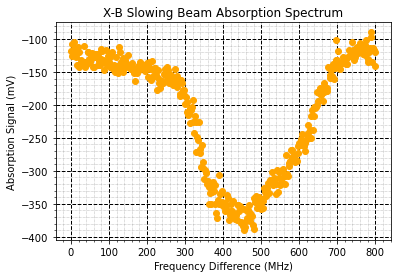

In [24]:
#plot absorption spectrum of X-B slowing beam

freq1 = dict3[run_names[0]][0]
sig1 = dict3[run_names[0]][1]*1e3

plt.plot(freq1, sig1, 'o', color='orange')
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.title('X-B Slowing Beam Absorption Spectrum')
plt.show()



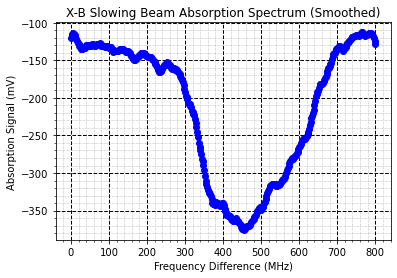

In [25]:
#try smoothing out the EOM off spectrum

from scipy.signal import savgol_filter

sig1_smooth = savgol_filter(sig1, window_length=19, polyorder=3)
plt.plot(freq1, sig1_smooth, 'o', color='blue')
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.title('X-B Slowing Beam Absorption Spectrum (Smoothed)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.show()

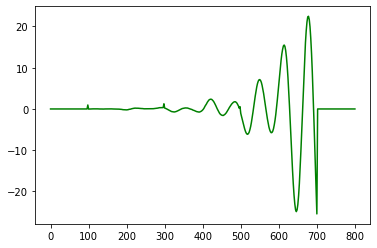

In [26]:
from scipy.signal import deconvolve

# Known Gaussian parameters
amplitude = -300  # replace with your amplitude
vertical_offset = -125  # replace with your vertical offset
horizontal_offset = 450  # replace with your horizontal offset
FWHM = 120  # replace with your FWHM

# Calculate standard deviation from FWHM
sigma = FWHM / np.sqrt(8 * np.log(2))

# Generate Gaussian
x = np.linspace(0, 800, 100)  # adjust as needed
gaussian = amplitude * np.exp(-(x - horizontal_offset)**2 / (2 * sigma**2)) + vertical_offset

# Deconvolve the signal
recovered, remainder = deconvolve(sig1_smooth, gaussian)
n = len(recovered)
s = (len(sig1_smooth)-n)//2
deconv = np.zeros(len(sig1_smooth))
deconv[s:len(sig1_smooth)-s-1] = recovered
sig1_deconv = deconv

plt.plot(freq1, sig1_deconv, color='green')
plt.show()

